In [1]:
import perfecthash.analysis as pha

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import os.path
from os.path import dirname
import perfecthash.analysis as pha
import pandas as pd

In [4]:
#from bokeh.io import output_file
#output_file('cl/cache-line-occupancy-heatmap.html')
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
def get_dfs_from_csv(csv):
    from perfecthash.path import join_path, dirname
    dname = dirname(csv)
    pha.convert_csv_to_parquet(csv, '.')
    parquet_path = csv.replace('.csv', '.parquet')
    # Load the df, then post-process.
    df = pha.df_from_parquet(parquet_path)
    df.KeysToEdgesRatio = df.NumberOfKeys / df.NumberOfEdges
    df.AddKeysElapsedCycles = (
        df.HashKeysElapsedCycles -
        df.AddHashedKeysElapsedCycles
    )
    df['AddKeysElapsedCyclesPerKey'] = (
        df.AddKeysElapsedCycles / df.NumberOfKeys
    )
    df['HashKeysElapsedCyclesPerKey'] = (
        df.HashKeysElapsedCycles / df.NumberOfKeys
    )
    df['VerifyMicrosecondsPerKey'] = (
        df.VerifyMicroseconds / df.NumberOfKeys
    )
    df.rename(columns={'DeltaHashMinimumCycles': 'Cycles'}, inplace=True)

    try:
        path = join_path(dname, 'events_FoundNewBestGraph.csv')
        nbdf = pd.read_csv(path)
    except:
        print(f'failed: {path}')
        nbdf = None
    try:
        path = join_path(dname, 'events_MemoryCoverageCacheLineCounts.csv')
        mcdf = pd.read_csv(path)
    except:
        print(f'failed: {path}')
        mcdf = None

    return (df, nbdf, mcdf)

def get_mcdf(keysname, attempt, mcdf):
    df = mcdf[(mcdf.Attempt == attempt) & (mcdf.KeysFileName == keysname)]
    cols = [ c for c in df.columns if c.startswith('CacheLine') ]
    counts = df[cols]
    values = counts.values
    return values

def get_mcdf_for_df_row(df, mcdf, attempt=None):
    assert len(df) == 1
    keys_filename = os.path.basename(df.KeysFullPath.values[0])
    if attempt is None:
        attempt = df.AttemptThatFoundBestGraph.values[0]
    d = mcdf[(mcdf.Attempt == attempt) & (mcdf.KeysFileName == keys_filename)]
    return d

def get_vals_from_mcdf(mcdf):
    cols = [ c for c in mcdf.columns if c.startswith('CacheLine') ]
    counts = mcdf[cols]
    values = counts.values
    return values

In [6]:
def get_cache_line_coverage_from_nbdf(nbdf):
    import numpy as np
    count = len(nbdf)
    keys = [
        f'NumberOfAssignedPerCacheLineCounts_{n}'
            for n in range(0, 17)
    ]
    values = nbdf[keys].values.astype(int)
    assert values.shape == (count, 17)
    #values = values.reshape(count, 17)
    keys = [ f'BestGraph{i}_Attempt' for i in range(1, count+1) ]
    attempts = nbdf['Attempt'].values
    columns = [ f'{i}' for i in range(0, 17) ]
    return (keys, values, attempts, columns)

def ridgeline_plot_nbdf(df, nbdf):
    import joypy
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib import cm
    #plt.ioff()
    keys_name = df.KeysName.values[0]
    hash_func = df.HashFunction.values[0]
    best_coverage_type = df.BestCoverageType.values[0]
    table_timestamp = df.TableTimestamp.values[0]
    (keys, values, attempts, columns) = get_cache_line_coverage_from_nbdf(nbdf)
    dfc = pd.DataFrame(values, columns=columns, index=attempts).sort_index()
    dft = dfc.T
    dft = dft[[ c for c in reversed(sorted(dft.columns)) ]]
    x_range = list(range(0, 17))
    (figure, axes) = joypy.joyplot(
        dft,
        kind="values",
        x_range=x_range,
        #labels=attempts,
        colormap=cm.rainbow,
        title=f"{keys_name} {hash_func}\n{best_coverage_type}\n{table_timestamp}",
        alpha=0.5,
        overlap=0.5,
        #ylim=True,
        grid=True,
        figsize=(10, 10),
    )
    axes[-1].set_xticks(x_range)
    axes[-1].set_yticks(dfc.index)
    #plt.draw()
    #plt.cla()
    #plt.clf()
    return (figure, axes)

In [7]:
(df, nbdf, mcdf) = get_dfs_from_csv(r'PerfectHashTableCreate_B8041ECB.csv')

In [8]:
nbdf = pha.update_df_with_seed_bytes(nbdf)

(<Figure size 1000x1000 with 14 Axes>,
 [<AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: title={'center': 'HologramWorld_31016 MultiplyShiftR\nHighestScore\n2022-12-22 21:24:59.992'}>])

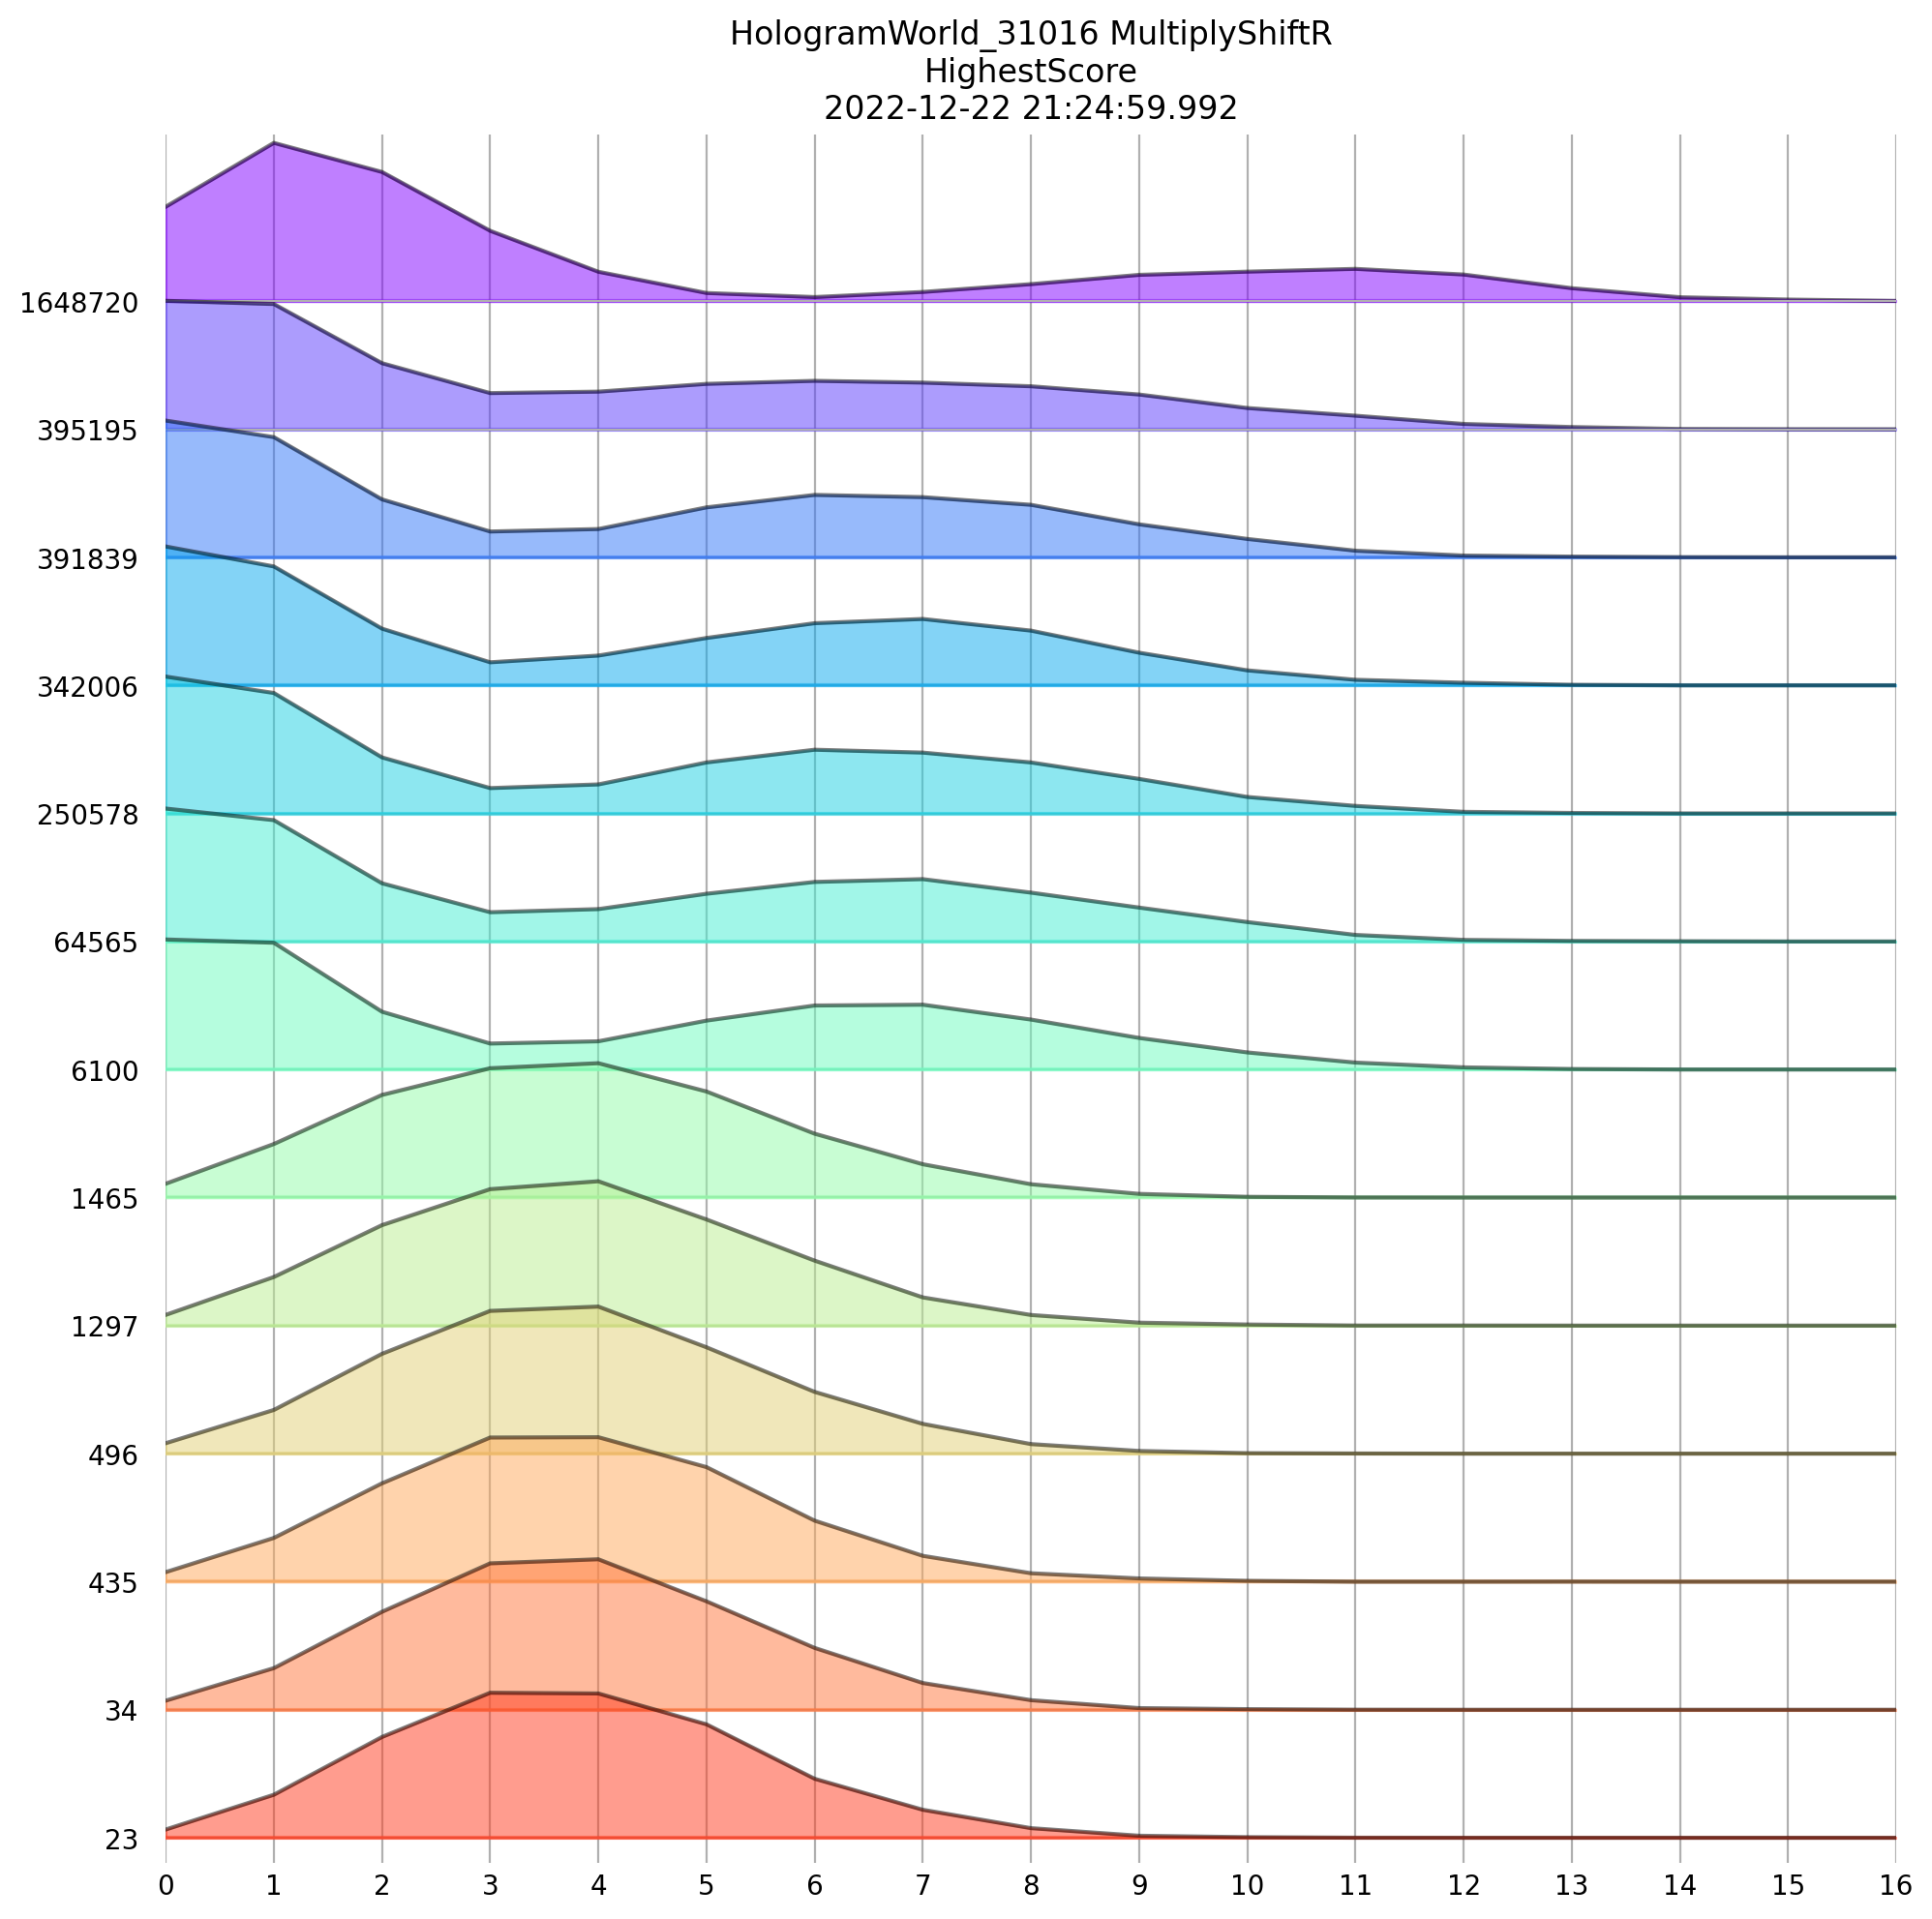

In [9]:
ridgeline_plot_nbdf(df, nbdf)

In [10]:
attempts = nbdf.Attempt.values
attempts

array([     34,      23,     435,     496,    1297,    1465,    6100,
         64565,  250578,  342006,  391839,  395195, 1648720], dtype=int64)

In [12]:
from perfecthash.path import basename

def get_mcdf_for_df_row(df, mcdf, attempt=None):
    assert len(df) == 1
    keys_filename = basename(df.KeysFullPath.values[0])
    if attempt is None:
        attempt = df.AttemptThatFoundBestGraph.values[0]
    d = mcdf[(mcdf.Attempt == attempt) & (mcdf.KeysFileName == keys_filename)]
    return d

def cache_line_occupancy_heatmap_grid_bokeh(df, nbdf, mcdf, attempts=None,
                                            width=None, height=None,
                                            sort_values=False,
                                            cmap=None,
                                            overlay_linregress=None):
    import numpy as np
    import pandas as pd

    import seaborn as sns

    from bokeh.io import (
        show,
    )

    from bokeh.plotting import (
        figure,
    )

    from bokeh.layouts import (
        row,
        column,
        gridplot,
    )

    from bokeh.models import (
        Rect,
        Label,
        Slope,
        Legend,
        TapTool,
        ColorBar,
        CustomJS,
        LabelSet,
        DataTable,
        LegendItem,
        BasicTicker,
        TableColumn,
        ColumnDataSource,
        LinearColorMapper,
        PrintfTickFormatter,
    )

    from datetime import timedelta

    from perfecthash.sourcefile import PerfectHashPdbexHeaderFile

    assert len(df) == 1, len(df)

    keys_name = df.KeysName.values[0]

    color_range = list(range(0, 17))

    if cmap is None:
        cmap = sns.color_palette('Spectral_r', n_colors=17)

    colors = cmap.as_hex()
    assert len(color_range) == len(colors)

    mapper = LinearColorMapper(palette=colors, low=0, high=16)

    tools = 'hover,save,reset,wheel_zoom,tap'

    if attempts is None:
        attempts = all_attempts = nbdf['Attempt'].values

    phh = PerfectHashPdbexHeaderFile()

    bct = { int(v): k for (k, v) in phh.best_coverage_types_dict.items() }
    nbdf['BestCoverageType'] = [ bct[i] for i in nbdf.CoverageType.values ]
    nbdf['BestCoverageValue'] = nbdf.CoverageValueAsDouble.values

    nbdf['Attempt_'] = [ f'{a:,}' for a in nbdf.Attempt.values ]
    nbdf['SolutionNumber_'] = [ f'{a:,}' for a in nbdf.SolutionNumber.values ]

    tds = [
        timedelta(milliseconds=int(m)) for m in nbdf.ElapsedMilliseconds.values
    ]

    nbdf['Elapsed'] = [ str(t) for t in tds ]

    nbdf['Seed1_'] = [ hex(v) for v in nbdf.Seed1.values ]
    nbdf['Seed2_'] = [ hex(v) for v in nbdf.Seed2.values ]
    nbdf['Seed3_Byte1_'] = [ hex(v) for v in nbdf.Seed3_Byte1.values ]
    nbdf['Seed3_Byte2_'] = [ hex(v) for v in nbdf.Seed3_Byte2.values ]

    new_best_cols = {
        'Attempt_': 'Attempt',
        'SolutionNumber_': 'Solution Number',
        'Elapsed': 'Elapsed',
        'BestCoverageValue': 'Best Coverage Value',
        'TotalNumberOfAssigned': 'Total Number of Assigned',
        'MaxGraphTraversalDepth': 'Max Graph Traversal Depth',
        'TotalGraphTraversals': 'Total Graph Traversals',
        'Seed1_': 'Seed1',
        'Seed2_': 'Seed2',
        'Seed3_Byte1_': 'Seed3 Byte1',
        'Seed3_Byte2_': 'Seed3 Byte2',
        'Slope': 'Slope',
        'Intercept': 'Intercept',
        'Score': 'Score',
        'Rank': 'Rank',
    }

    columns = [
        TableColumn(field=k, title=t) for (k, t) in new_best_cols.items()
    ]
    top_dt = DataTable(
        source=ColumnDataSource(nbdf[new_best_cols.keys()]),
        columns=columns,
        width=(width * 3) if width else 1200,
        autosize_mode='force_fit',
        height=300,
        #height=height or 600,
    )

    figures = []

    layouts = [top_dt]

    for attempt in attempts:

        # Heatmap
        mcdf_attempt = get_mcdf_for_df_row(df, mcdf, attempt=attempt)

        cache_line_cols = [
            c for c in mcdf_attempt.columns if c.startswith('CacheLine_')
        ]

        cols = [ 'PageIndex', ] + cache_line_cols

        mdf = mcdf_attempt[cols]

        renamed_cols = { 'PageIndex': 'Page' }
        for (i, col) in enumerate(cache_line_cols):
            renamed_cols[col] = str(i)

        mdf = mdf.rename(columns=renamed_cols)
        mdf = mdf.set_index('Page')
        mdf = mdf.set_index(np.flip(mdf.index))
        mdf.columns.name = 'CacheLine'

        pages = [ str(i) for i in mdf.index ]
        cache_lines = list(mdf.columns)

        pdf = pd.DataFrame(mdf.stack(), columns=['Count']).reset_index()
        cds = ColumnDataSource(pdf)

        tooltips = [
            ('Page', '@Page'),
            ('Cache Line', '@CacheLine'),
            ('Count', '@Count'),
        ]

        p = figure(
            title=f'Attempt: {attempt:,}',
            width=width or 400,
            height=height or 600,
            x_range=cache_lines,
            y_range=pages,
            match_aspect=True,
            tools=tools,
            tooltips=tooltips,
        )

        p.grid.grid_line_color = None
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.minor_tick_line_color = None
        p.axis.major_label_text_font_size = '0pt'
        p.axis.major_label_standoff = 0
        p.xaxis.axis_label = 'Cache Line'
        p.yaxis.axis_label = 'Page'

        r = p.rect(
            x='CacheLine',
            y='Page',
            width=1, height=1,
            source=cds,
            fill_color={'field': 'Count', 'transform': mapper},
            line_color='white',
        )

        color_bar = ColorBar(color_mapper=mapper,
                             major_label_text_font_size="7px",
                             ticker=BasicTicker(desired_num_ticks=len(colors)),
                             formatter=PrintfTickFormatter(format="%d"),
                             title='Number of Assigned per Cache Line',
                             label_standoff=6, border_line_color=None)

        p.add_layout(color_bar, 'right')

        heatmap = p
        heatmap_cds = cds

        # Bar chart
        keys = [
            f'NumberOfAssignedPerCacheLineCounts_{n}'
                for n in range(0, 17)
        ]
        ndf_attempt = nbdf[nbdf.Attempt == attempt]
        ndf = ndf_attempt[keys]
        counts = ndf.values[0].astype(int)
        cache_lines = [ str(i) for i in range(0, 17) ]
        cds = ColumnDataSource(data={
            'CacheLine': cache_lines,
            'Count': counts,
            'Color': colors,
        })

        y_range = [ str(c) for c in np.unique(np.flip(counts)) ]

        p = figure(
            title=f'Attempt: {attempt:,}',
            width=width or 400,
            height=height or 600,
            x_range=cache_lines,
            match_aspect=True,
            tools='hover,tap',
            tooltips='@Count'
        )

        p.vbar(
            x='CacheLine',
            top='Count',
            width=0.9,
            color='Color',
            alpha=0.8,
            source=cds
        )

        labels = LabelSet(
            x='CacheLine',
            y='Count',
            text='Count',
            text_align='center',
            text_font_size='8px',
            source=cds,
            render_mode='css',
        )

        p.add_layout(labels)

        na = ndf_attempt.squeeze()
        text = (
            f'Slope:     {np.around(na.Slope, 5)}\n'
            f'Intercept: {np.around(na.Intercept, 5)}\n'
            f'Score:     {np.around(na.Score, 5):,}\n'
            f'Rank:      {np.around(na.Rank, 5)}\n'
        )
        label = Label(
            #x=10,
            #y=1100,
            #x_units='data',
            #y_units='data',
            x=185,
            y=495,
            x_units='screen',
            y_units='screen',
            text=text,
            render_mode='css',
            text_font='Comic Code Ligatures',
            #text_font_style='italic',
            text_font_size='9px',
            background_fill_color='white',
            border_line_alpha=0.4,
            border_line_color='darkgrey',
            border_line_width=0.8,
            border_line_cap='round',
            border_line_join='bevel',
        )
        p.add_layout(label)

        # Add the slopes.
        slope = Slope(
            gradient=na.Slope,
            y_intercept=na.Intercept,
            line_color='grey',
            line_dash='dashed',
            line_alpha=0.8,
        )
        p.add_layout(slope)

        if overlay_linregress:
            from scipy.stats import linregress
            lr = linregress(x=list(range(1, 17)), y=counts[1:],
                            alternative='less')
            slope = Slope(
                gradient=lr.slope,
                y_intercept=lr.intercept,
                line_color='darkred',
                line_dash='dashed',
                line_alpha=0.5,
            )
            p.add_layout(slope)

            text = (
                f'Slope:      {np.around(lr.slope, 5)}\n'
                f'Intercept:  {np.around(lr.intercept, 5)}\n'
                f'RValue:     {np.around(lr.rvalue, 5)}\n'
                f'PValue:     {np.around(lr.pvalue, 5)}\n'
                f'StdErr:     {np.around(lr.stderr, 5)}\n'
                f'Int StdErr: {np.around(lr.intercept_stderr, 5)}\n'
            )
            label = Label(
                #x=10,
                #y=1100,
                #x_units='data',
                #y_units='data',
                x=185,
                y=395,
                x_units='screen',
                y_units='screen',
                text=text,
                render_mode='css',
                text_font='Comic Code Ligatures',
                #text_font_style='italic',
                text_font_size='9px',
                text_color='darkred',
                background_fill_color='white',
                border_line_alpha=0.4,
                border_line_color='darkgrey',
                border_line_width=0.8,
                border_line_cap='round',
                border_line_join='bevel',
            )
            p.add_layout(label)

        p.y_range.start = 0
        p.y_range.end = max(counts) + 50

        code = """
            const bc = barchart.data;
            const x = Math.floor(cb_data.geometries.x);
            const y = Math.floor(cb_data.geometries.y);
            var is_valid = false;
            if ((x >= 0) && (x <= 16)) {
                count = bc.Count[x];
                if (y <= count) {
                    is_valid = true;
                }
            }
            const selected_count = is_valid ? x : -1;

            const d = heatmap.data;

            var count;
            var new_selection = [];

            for (var i = 0; i < d['index'].length; i++) {
                count = d['Count'][i];
                if (count == selected_count) {
                    new_selection.push(i);
                }
            }

            heatmap.selected.indices = new_selection;

            globalThis.ChartTrigger = 'barchart';

            heatmap.change.emit();
        """
        barchart_cds = cds

        args = {
            'heatmap': heatmap_cds,
            'barchart': barchart_cds,
        }
        callback = CustomJS(args=args, code=code)
        taptool = p.select(type=TapTool)
        taptool.callback = callback

        barchart_cds.selected.js_on_change(
            'indices',
            CustomJS(
                args=args,
                code="""
                    if (cb_obj.indices.length == 0) {
                        globalThis.ChartTrigger = 'heatmap_clear';
                        heatmap.selected.indices = heatmap.data.index;
                    }
                """
            )
        )

        taptool = heatmap.select(type=TapTool)
        taptool.callback = CustomJS(
            args=args,
            code="""
                const d = heatmap.data;
                const selected_index = heatmap.selected.indices[0];
                const selected_count = d['Count'][selected_index];

                if (globalThis.HeatmapSelectedIndex) {
                    const previous_index = globalThis.HeatmapSelectedIndex;
                    const previous_count = d['Count'][previous_index];
                    if (previous_count == selected_count) {
                        globalThis.ChartTrigger = 'heatmap_unselect';
                        globalThis.HeatmapSelectedIndex = null;
                        heatmap.selected.indices = heatmap.data.index;
                        indices = barhart.data.Count.keys();
                        barchart.selected.indices = Array.from(indices);
                        heatmap.change.emit();
                        barchart.change.emit();
                        return;
                    }
                }

                var count;
                var new_selection = [];

                for (var i = 0; i < d['index'].length; i++) {
                    count = d['Count'][i];
                    if (count == selected_count) {
                        new_selection.push(i);
                    }
                }

                globalThis.ChartTrigger = 'heatmap_select';
                globalThis.HeatmapSelectedIndex = selected_index;

                heatmap.selected.indices = new_selection;

                barchart.selected.indices = [selected_count];

                heatmap.change.emit();
                barchart.change.emit();
            """
        )


        barchart = p

        # Data table

        dtdf = ndf_attempt[new_best_cols.keys()].copy()
        dtdf.rename(columns=new_best_cols, inplace=True)
        data = dtdf.T
        dts = ColumnDataSource(data={
            'Name': data.index,
            'Value': data.values,
        })
        columns = [
            TableColumn(field='Name', title='Name'),
            TableColumn(field='Value', title='Value'),
        ]
        datatable = DataTable(
            source=dts,
            columns=columns,
            width=width or 400,
            height=height or 600,
            autosize_mode='force_fit',
        )

        # Finalize
        layout = row(barchart, heatmap, datatable)
        layouts.append(layout)

    grid = gridplot(layouts, ncols=1)

    show(grid)


In [13]:
cache_line_occupancy_heatmap_grid_bokeh(df, nbdf, mcdf, attempts=attempts, overlay_linregress=False)